## Dependencies

In [1]:
import json, warnings, shutil, glob, time
from scripts_lr_schedulers import *
from jigsaw_utility_scripts import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [2]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [3]:
database_base_path = '/kaggle/input/jigsaw-data-split-roberta-192-ratio-1-clean-tail/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", usecols=['comment_text', 'toxic', 'lang'])

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print('Validation samples: %d' % len(valid_df))
display(valid_df.head())

# Unzip files
!tar -xvf /kaggle/input/jigsaw-data-split-roberta-192-ratio-1-clean-tail/fold_1.tar.gz

Train samples: 267220


,comment_text,toxic,toxic_int,fold_1,fold_2,fold_3,fold_4,fold_5
0,It would be helpful if either story about this...,0.20000,0,train,train,validation,train,train
1,What's missing in your stats is the percentage...,0.00000,0,train,train,validation,train,train
2,Great another mediocre season.,0.60000,1,train,train,validation,train,train
3,Putting your money where your mouth is. Can't ...,0.65625,1,validation,train,train,train,train
4,Just call me Nemo.... I'm writing about the HB...,0.00000,0,train,train,train,train,validation


Validation samples: 8000


,comment_text,lang,toxic
0,Este usuario ni siquiera llega al rango de ...,es,0
1,Il testo di questa voce pare esser scopiazzato...,it,0
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


fold_1/
fold_1/y_valid_int.npy
fold_1/y_train_int.npy
fold_1/x_valid.npy
fold_1/x_valid_tail.npy
fold_1/y_valid.npy
fold_1/x_train_tail.npy
fold_1/y_train.npy
fold_1/x_train.npy


# Model parameters

In [4]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 192,
  "BATCH_SIZE": 128,
  "EPOCHS": 7,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": 1,
  "N_FOLDS": 1,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

## Learning rate schedule

Learning rate schedule: 1e-07 to 1e-05 to 1e-05


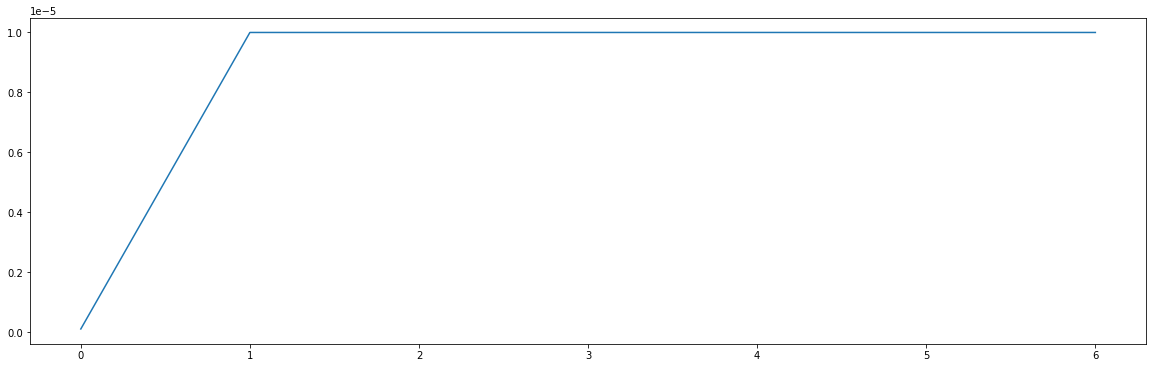

In [5]:
rng = [i for i in range(config['EPOCHS'])]
y = [get_constant_schedule_with_warmup(x, warmup_epochs=1, lr_start=1e-7, 
                                       lr_max=config['LEARNING_RATE']) for x in rng]

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [6]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x_avg = layers.GlobalAveragePooling1D()(last_hidden_state)
    x_max = layers.GlobalMaxPooling1D()(last_hidden_state)
    x = layers.Concatenate()([x_avg, x_max])
    x = layers.Dropout(0.3)(x)
    
    output = layers.Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

# Train

In [7]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print('\nFOLD: %d' % (n_fold+1))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold+1)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy').reshape(x_train.shape[1], 1).astype(np.float32)
    x_valid_ml = np.load(database_base_path + 'x_valid.npy')
    y_valid_ml = np.load(database_base_path + 'y_valid.npy').reshape(x_valid_ml.shape[1], 1).astype(np.float32)
    
    #################### ADD TAIL ####################
    x_train = np.hstack([x_train, np.load(base_data_path + 'x_train_tail.npy')])
    y_train = np.vstack([y_train, y_train])
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid_ml.shape[1] // config['BATCH_SIZE']
    
    ### Delete data dir
    shutil.rmtree(base_data_path)
    
    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss = loss_fn(y, probabilities)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            train_accuracy.update_state(y, probabilities)
            train_auc.update_state(y, probabilities)
            train_loss.update_state(loss)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss = loss_fn(y, probabilities)
            valid_accuracy.update_state(y, probabilities)
            valid_auc.update_state(y, probabilities)
            valid_loss.update_state(loss)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))
    
    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold+1)
    
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        
        class LRSchedule(optimizers.schedules.LearningRateSchedule):
            def __call__(self, step):
                return get_constant_schedule_with_warmup(epoch=step//step_size, warmup_epochs=1, 
                                                         lr_start=1e-7, lr_max=config['LEARNING_RATE'])
        optimizer = optimizers.Adam(learning_rate=LRSchedule())
        loss_fn = losses.binary_crossentropy

        train_accuracy = metrics.BinaryAccuracy()
        valid_accuracy = metrics.BinaryAccuracy()
        train_auc = metrics.AUC()
        valid_auc = metrics.AUC()
        train_loss = metrics.Sum()
        valid_loss = metrics.Sum()
        
    # Setup training loop
    step = 0
    epoch = 0
    epoch_steps = 0
    epoch_start_time = time.time()
    history = {'loss': [], 'auc': [], 'accuracy': [], 
               'val_loss': [], 'val_auc': [], 'val_accuracy': []}
    patience_cnt = 0
    best_val = float("inf")

    print(f'Train for {step_size} steps, validate for {valid_step_size} steps')
    ### Train model
    while True:
        train_step(train_data_iter)
        epoch_steps += step_size
        step += step_size

        # validation run at the end of each epoch
        if (step // step_size) > epoch:
            # validation run
            valid_epoch_steps = 0
            valid_step(valid_data_iter)
            valid_epoch_steps += valid_step_size

            # compute metrics
            history['accuracy'].append(train_accuracy.result().numpy())
            history['auc'].append(train_auc.result().numpy())
            history['loss'].append(train_loss.result().numpy() / (config['BATCH_SIZE'] * epoch_steps))
            history['val_accuracy'].append(valid_accuracy.result().numpy())
            history['val_auc'].append(valid_auc.result().numpy())
            history['val_loss'].append(valid_loss.result().numpy() / (config['BATCH_SIZE'] * valid_epoch_steps))

            # report metrics
            epoch_time = time.time() - epoch_start_time
            print('\nEPOCH {:d}/{:d}'.format(epoch+1, config['EPOCHS']))
            print('time: {:0.1f}s'.format(epoch_time),
                  'loss: {:0.4f}'.format(history['loss'][-1]),
                  'auc: {:0.4f}'.format(history['auc'][-1]),
                  'accuracy: {:0.4f}'.format(history['accuracy'][-1]),
                  'val_loss: {:0.4f}'.format(history['val_loss'][-1]),
                  'val_auc: {:0.4f}'.format(history['val_auc'][-1]),
                  'val_accuracy: {:0.4f}'.format(history['val_accuracy'][-1]))
            print('LearningRate: {:0.4g}'.format(get_constant_schedule_with_warmup(epoch, warmup_epochs=1, lr_start=1e-7, 
                                                                                   lr_max=config['LEARNING_RATE'])))

            # set up next epoch
            epoch = step // step_size
            epoch_steps = 0
            epoch_start_time = time.time()
            train_accuracy.reset_states()
            valid_accuracy.reset_states()
            train_auc.reset_states()
            valid_auc.reset_states()
            train_loss.reset_states()
            valid_loss.reset_states()

            if epoch <= config['EPOCHS']:
                # Early stopping monitor
                if history['val_loss'][-1] <= best_val:
                    best_val = history['val_loss'][-1]
                    model.save_weights(model_path)
                    print('Saved model weights at "%s"' % model_path)
                else:
                    patience_cnt += 1
                if patience_cnt >= config['ES_PATIENCE']:
                    print('Epoch %05d: early stopping' % epoch)
                    break
            else:
                model.save_weights(model_path)
                print('Training finished saved model weights at "%s"' % model_path)
                break
        
    history_list.append(history)
    model.load_weights(model_path)
    
    # Fine-tune on validation set
#     print('\nFine-tune on validation set')
#     n_steps2 = x_valid_ml.shape[1] // config['BATCH_SIZE']

#     history2 = model.fit(get_training_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO),
#                          steps_per_epoch=n_steps2,
#                          epochs=config['EPOCHS'],
#                          verbose=2).history
    
    # Make predictions
#     train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE'], AUTO))
#     valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE'], AUTO))
    valid_ml_preds = model.predict(get_test_dataset(x_valid_ml, config['BATCH_SIZE'], AUTO))
    
#     k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'train', 'pred_%d' % (n_fold+1)] = np.round(train_preds)
#     k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'validation', 'pred_%d' % (n_fold+1)] = np.round(valid_preds)
    valid_df['pred_%d' % (n_fold+1)] = valid_ml_preds


FOLD: 1
Train for 3340 steps, validate for 62 steps

EPOCH 1/7
time: 1203.1s loss: 0.6366 auc: 0.7180 accuracy: 0.3755 val_loss: 0.6838 val_auc: 0.8837 val_accuracy: 0.5432
LearningRate: 1e-07
Saved model weights at "model_fold_1.h5"

EPOCH 2/7
time: 989.9s loss: 0.4131 auc: 0.9461 accuracy: 0.4641 val_loss: 0.3036 val_auc: 0.9302 val_accuracy: 0.8717
LearningRate: 1e-05
Saved model weights at "model_fold_1.h5"

EPOCH 3/7
time: 992.2s loss: 0.3842 auc: 0.9594 accuracy: 0.4726 val_loss: 0.2559 val_auc: 0.9248 val_accuracy: 0.8751
LearningRate: 1e-05
Saved model weights at "model_fold_1.h5"

EPOCH 4/7
time: 1007.0s loss: 0.3696 auc: 0.9661 accuracy: 0.4774 val_loss: 0.2558 val_auc: 0.9168 val_accuracy: 0.8724
LearningRate: 1e-05
Saved model weights at "model_fold_1.h5"

EPOCH 5/7
time: 991.7s loss: 0.3567 auc: 0.9729 accuracy: 0.4813 val_loss: 0.2489 val_auc: 0.9222 val_accuracy: 0.8740
LearningRate: 1e-05
Saved model weights at "model_fold_1.h5"

EPOCH 6/7
time: 992.7s loss: 0.3455 auc

## Model loss graph

Fold: 1


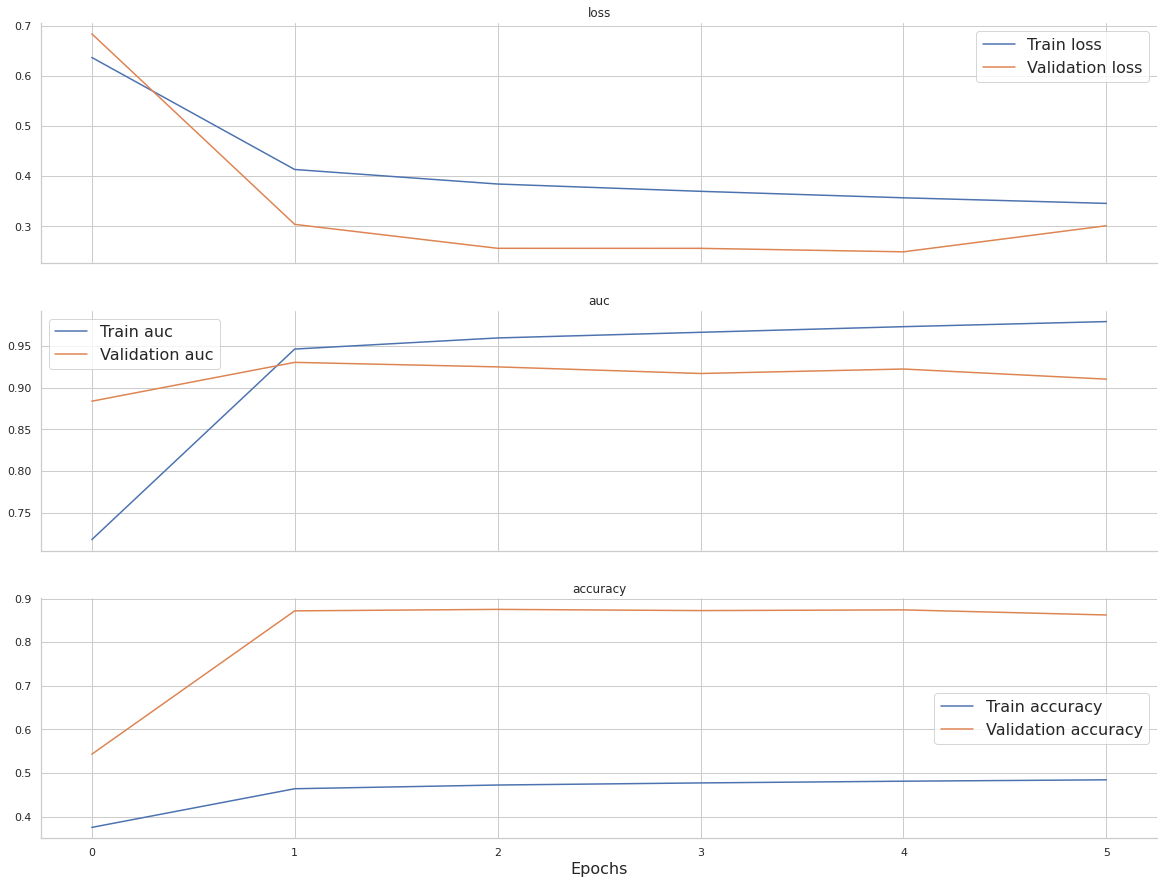

In [8]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [9]:
# display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

# Confusion matrix

In [10]:
# for n_fold in range(config['N_FOLDS']):
#     print('Fold: %d' % (n_fold+1))
#     train_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'train']
#     validation_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'validation'] 
#     plot_confusion_matrix(train_set['toxic'], train_set['pred_%d' % (n_fold+1)], 
#                           validation_set['toxic'], validation_set['pred_%d' % (n_fold+1)])

# Model evaluation by language

In [11]:
display(evaluate_model_lang(valid_df, config['N_FOLDS']).style.applymap(color_map))

,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.920172,0.920172
es,0.891914,0.891914
it,0.889514,0.889514
tr,0.980944,0.980944


# Visualize predictions

In [12]:
pd.set_option('max_colwidth', 120)
print('English validation set')
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

print('Multilingual validation set')
display(valid_df[['comment_text', 'toxic'] + [c for c in valid_df.columns if c.startswith('pred')]].head(10))

English validation set


,comment_text,toxic
0,It would be helpful if either story about this incident contained additional facts about what happened. Was the vict...,0.20000
1,What's missing in your stats is the percentage of Canadians who believed there was a clean exit to this mess. I'm no...,0.00000
2,Great another mediocre season.,0.60000
3,"Putting your money where your mouth is. Can't fault him for that, for sure. Oh, wait, that's right, he had no proble...",0.65625
4,"Just call me Nemo.... I'm writing about the HB visa program and so is the author of the article. There are , opening...",0.00000
5,"you are an incredible optimist. You see shiny bright full, I see dark clouds obscuring the edge that humans are tott...",0.00000
6,What about Junior's vacation investigation; Morneau and his conflicts of interest; Junior's and Morneau's hidden mon...,0.60000
7,"If you are not well later in life, you need the extra money to cover home care or a residence. Or perhaps, you are h...",0.00000
8,"scuppers.. Facts and reality won't help your case. You'll need to get into the gutter with false facts, false accusa...",1.00000
9,"Yes, electoral districts that voted for Trump had higher median incomes. No, they did not have more education So the...",0.00000


Multilingual validation set


,comment_text,toxic,pred_1
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,0,0.855974
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",0,0.004544
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",1,0.642692
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,0,0.003615
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,0,0.004130
5,"güzel, zaten kaynaklandırması zor subjektif kategoriler bunlar. bazı maddelerden çıkartmak, kiminden çıkartıp kimind...",0,0.013149
6,"No es mala idea. De hecho, yo estaba pensando descolgarme ya del reto mensual, pero esto vuelve a ilusionarme. El pr...",0,0.004909
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık çok teşekkürler.Önceki sürümleri araştırdım.13 Haziran 2010 da Kullanıc...",0,0.003985
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umarım her şey istediğin gibidir. Bu arada Janet Jackson maddesi seçkin ma...,0,0.013142
9,"Creo que es importante que podamos reconocer a gente como Victor Manuel Vucetich , quien es originario de Tampico y ...",0,0.035374


# Test set predictions

In [13]:
model_path_list = glob.glob('/kaggle/working/' + '*.h5')
model_path_list.sort()
print('Models to predict:')
print(*model_path_list, sep = "\n")

Models to predict:
/kaggle/working/model_fold_1.h5


In [14]:
x_test = np.load(database_base_path + 'x_test.npy')
NUM_TEST_IMAGES = x_test.shape[1]
test_preds = np.zeros((NUM_TEST_IMAGES, 1))

for model_path in model_path_list:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print(model_path)
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        model.load_weights(model_path)

    test_preds += model.predict(get_test_dataset(x_test, config['BATCH_SIZE'], AUTO)) / len(model_path_list)

/kaggle/working/model_fold_1.h5


In [15]:
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = test_preds
submission.to_csv('submission.csv', index=False)

display(submission.describe())
display(submission.head(10))

,id,toxic
count,63812.000000,63812.000000
mean,31905.500000,0.228301
std,18421.082026,0.296078
min,0.000000,0.000473
25%,15952.750000,0.008181
50%,31905.500000,0.048623
75%,47858.250000,0.419598
max,63811.000000,0.999978


,id,toxic
0,0,0.003032
1,1,0.003406
2,2,0.519961
3,3,0.003569
4,4,0.010785
5,5,0.080606
6,6,0.004570
7,7,0.011192
8,8,0.645208
9,9,0.191022
